In [12]:
import pandas as pd
import numpy as np
import os

# they all xls!
file_name = '25-2'  # temprature-category,renamed ahead
data_dir = os.path.join(os.getcwd(), 'datas')
file_path_xlsx = os.path.join(data_dir, f'{file_name}.xlsx')
file_path_xls = os.path.join(data_dir, f'{file_name}.xls')

if os.path.exists(file_path_xlsx):
    target_file = file_path_xlsx
elif os.path.exists(file_path_xls):
    target_file = file_path_xls

xl = pd.ExcelFile(target_file)
sheets_to_process = xl.sheet_names[1:] 
all_frames = []

for sheet in sheets_to_process:
    raw = pd.read_excel(target_file, sheet_name=sheet, header=None)
    current_df = pd.DataFrame()
    for i in range(min(50, len(raw))):
        if str(raw.iloc[i, 1]).strip() == 'Test_Time(s)':
            raw.columns = [str(x).strip() for x in raw.iloc[i]]
            current_df = raw.iloc[i+1:].reset_index(drop=True)
            break
    if not current_df.empty and current_df.shape[1] > 1:#sometimes no data
        all_frames.append(current_df)

if not all_frames:
    raise ValueError("check it up dude......")

df = pd.concat(all_frames, ignore_index=True)

# metrology data
col_time = 'Test_Time(s)' if 'Test_Time(s)' in df.columns else 'Time'
col_volt = next((c for c in df.columns if 'Volt' in c), 'mV')
col_curr = next((c for c in df.columns if 'Curr' in c or 'Amp' in c), 'mA')

df['Time'] = pd.to_numeric(df.get(col_time, np.nan), errors='coerce')
v_raw = pd.to_numeric(df.get(col_volt, np.nan), errors='coerce')
i_raw = pd.to_numeric(df.get(col_curr, np.nan), errors='coerce')
df['V'] = v_raw / 1000.0 if ('mV' in col_volt or v_raw.mean() > 100) else v_raw
df['I'] = i_raw / 1000.0 if ('mA' in col_curr or abs(i_raw.mean()) > 10) else i_raw

# wash NaN
df.dropna(subset=['Time', 'V', 'I'], inplace=True)
df.reset_index(drop=True, inplace=True)

# just cut off when voltage start to rise
if not df.empty:
    min_v_idx = df['V'].idxmin()
    min_v_val = df['V'].iloc[min_v_idx]
    
    # locating cut-off point
    df = df.iloc[:min_v_idx+1].reset_index(drop=True)

if not df.empty:
    df['Time'] = df['Time'] - df['Time'].iloc[0]


output_path = os.path.join(data_dir, f'processed_{file_name}.csv')
df.to_csv(output_path, index=False)
print(f'saved to {output_path}')


saved to f:\Data\work document\pyworkplace\math-match\battery\pure\datas\processed_25-2.csv


Start global optimization (6th-order OCV, V > 3.25V)...

Success!
R0=0.09413, R1=0.02882, tau1=10.00, R2=0.02356, tau2=500.00


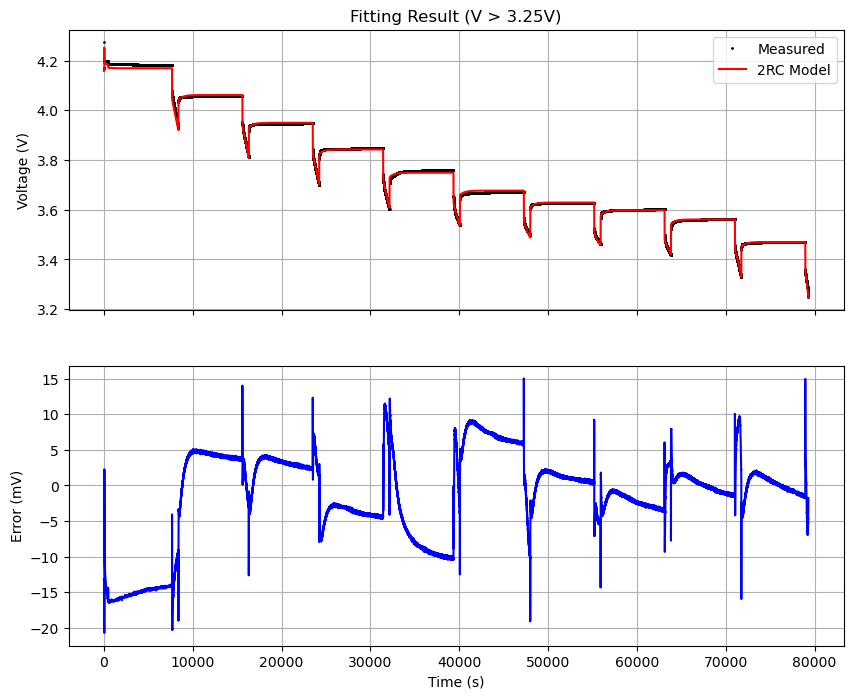

Model saved to: f:\Data\work document\pyworkplace\math-match\battery\pure\model\model_parameters_poly_25-2.json


In [13]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import json

# Differential Equations (2RC Model):
# dV1/dt = -V1/tau1 + I * R1 / tau1
# dV2/dt = -V2/tau2 + I * R2 / tau2
# V_terminal = OCV(Ah) + V1 + V2 + I * R0
# OCV(Ah) ~ 6th-order polynomial: p6*Ah^6 + ... + p1*Ah + p0
# note:it takes minutes for Ah calculation

def simulate_2rc(params, t, I, dt):
    # params: R0, R1, tau1, R2, tau2, p6, p5, p4, p3, p2, p1, p0
    R0, R1, tau1, R2, tau2 = params[:5]
    ocv_coeffs = params[5:]
    
    tau1 = max(tau1, 1e-2)
    tau2 = max(tau2, 1e-2)
    
    n = len(t)
    V_pred = np.zeros(n)
    v1, v2, cumulative_Ah = 0.0, 0.0, 0.0
    
    # Init V (Ah=0 -> OCV=p0)
    V_pred[0] = ocv_coeffs[-1] + I[0] * R0
    
    for k in range(1, n):
        d_t = dt[k-1]
        i_prev = I[k-1]
        cumulative_Ah += i_prev * d_t / 3600.0
        
        alpha1 = np.exp(-d_t / tau1)
        alpha2 = np.exp(-d_t / tau2)
        v1 = v1 * alpha1 + R1 * i_prev * (1 - alpha1)
        v2 = v2 * alpha2 + R2 * i_prev * (1 - alpha2)
        
        ocv_now = np.polyval(ocv_coeffs, cumulative_Ah)
        V_pred[k] = ocv_now + v1 + v2 + I[k] * R0
        
    return V_pred

def objective_function(params, t, I, V_measured, dt):
    V_pred = simulate_2rc(params, t, I, dt)
    return np.mean((V_pred - V_measured)**2)

# get data & filter low voltage
fit_cutoff_v = 3.25 # cutoff voltage，sometimes need experimentally set
df_fit = df[df['V'] > fit_cutoff_v].reset_index(drop=True)

t_data = df_fit['Time'].values
v_data = df_fit['V'].values
i_data = df_fit['I'].values
dt_Array = np.maximum(np.diff(t_data), 1e-3)

# init bounds and guess
# R0, R1, tau1, R2, tau2, p6, p5, p4, p3, p2, p1, p0
# Initial OCV ~ v_data[0] (p0)
x0 = [0.05, 0.02, 10.0, 0.05, 500.0, 0, 0, 0, 0, 0, 0, v_data[0]]

bounds = [
    (1e-4, 1.0), (1e-4, 1.0), (1.0, 300.0), 
    (1e-4, 2.0), (100.0, 10000.0), 
    (None, None), (None, None), (None, None), 
    (None, None), (None, None), (None, None), (2.0, 5.0)
]

print(f"Start global optimization (6th-order OCV, V > {fit_cutoff_v}V)...")
res = minimize(
    objective_function, x0, args=(t_data, i_data, v_data, dt_Array), 
    method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 5000}
)

if res.success:
    params = res.x
    R0, R1, tau1, R2, tau2 = params[:5]
    ocv_coeffs = params[5:].tolist()
    print(f"\nSuccess!\nR0={R0:.5f}, R1={R1:.5f}, tau1={tau1:.2f}, R2={R2:.5f}, tau2={tau2:.2f}")
    
    # visualization
    V_fit = simulate_2rc(params, t_data, i_data, dt_Array)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    ax1.plot(t_data, v_data, 'k.', markersize=2, label='Measured')
    ax1.plot(t_data, V_fit, 'r-', linewidth=1.5, label='2RC Model')
    ax1.legend(); ax1.set_ylabel('Voltage (V)'); ax1.grid(True)
    ax1.set_title(f'Fitting Result (V > {fit_cutoff_v}V)')
    
    ax2.plot(t_data, (V_fit - v_data)*1000, 'b')
    ax2.set_ylabel('Error (mV)'); ax2.set_xlabel('Time (s)'); ax2.grid(True)
    plt.show()

    # save to current_dir/model
    model_dir = os.path.join(os.getcwd(), 'model')
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
        
    json_path = os.path.join(model_dir, f'model_parameters_poly_{file_name}.json')
    params_dict = {
        "R0": R0, "R1": R1, "tau1": tau1, 
        "R2": R2, "tau2": tau2, 
        "OCV_poly_coeffs": ocv_coeffs
    }
    with open(json_path, 'w') as f:
        json.dump(params_dict, f, indent=4)
    print(f"Model saved to: {json_path}")
    
else:
    print("Optimization failed:", res.message)

Loaded base model: f:\Data\work document\pyworkplace\math-match\battery\pure\model\model_parameters_poly_25-2.json
reading 0-2.xlsx...
reading 45-2.xlsx...
Optimizing Temp Coeffs (Ea)...
Done! Ea_R=7210.8, Ea_Pol=20000.0


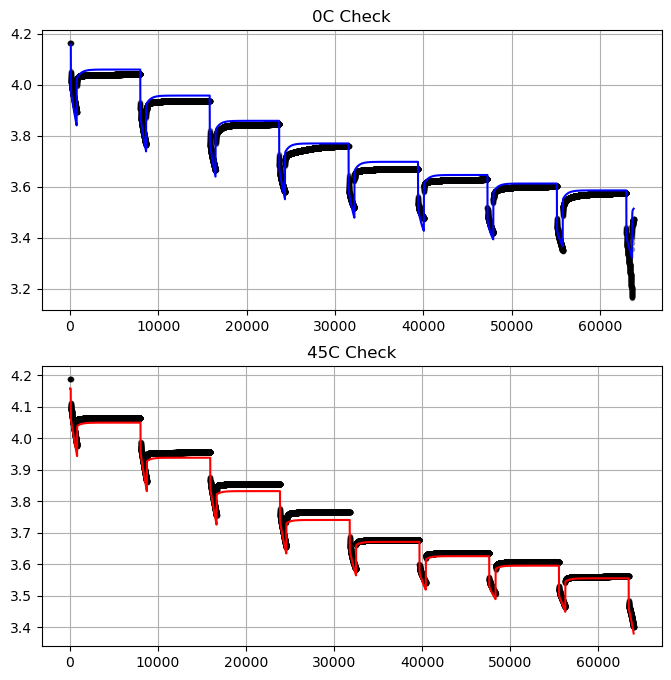

saved -> f:\Data\work document\pyworkplace\math-match\battery\pure\model\model_parameters_temp_optimized.json


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import json

# unlike cell 1, we need to load multiple files here
def get_clean_data(path):
    if not os.path.exists(path): 
        # try xls if xlsx missing
        path = path.replace('.xlsx', '.xls')
        if not os.path.exists(path): return None
        
    print(f"reading {os.path.basename(path)}...")
    try:
        xls = pd.ExcelFile(path)
        # pick data sheet
        sheet = next((s for s in xls.sheet_names if 'Data' in s or 'Channel' in s), xls.sheet_names[0])
        df = pd.read_excel(path, sheet_name=sheet)
    except:
        df = pd.read_csv(path, sep='\t')

    # fix headers
    if 'Test_Time(s)' not in df.columns:
        for i in range(min(50, len(df))):
            row = [str(x).strip() for x in df.iloc[i]]
            if 'Test_Time(s)' in row or 'Data_Point' in row:
                df.columns = row
                df = df.iloc[i+1:].reset_index(drop=True)
                break
    
    # standard columns
    col_t = 'Test_Time(s)' if 'Test_Time(s)' in df.columns else 'Time'
    col_v = next((c for c in df.columns if 'Volt' in c), 'mV')
    col_i = next((c for c in df.columns if 'Curr' in c or 'Amp' in c), 'mA')

    df['t'] = pd.to_numeric(df.get(col_t, np.nan), errors='coerce')
    v_raw = pd.to_numeric(df.get(col_v, np.nan), errors='coerce')
    i_raw = pd.to_numeric(df.get(col_i, np.nan), errors='coerce')

    # auto unit fix
    df['v'] = v_raw / 1000.0 if ('mV' in col_v or v_raw.mean() > 100) else v_raw
    df['i'] = i_raw / 1000.0 if ('mA' in col_i or abs(i_raw.mean()) > 10) else i_raw

    df.dropna(subset=['t', 'v', 'i'], inplace=True)
    
    # cut data before current starts (discharge usually negative)
    start_idxs = df.index[df['i'] < -0.05].tolist()
    if start_idxs:
        s = max(0, start_idxs[0] - 10) 
        df = df.iloc[s:].reset_index(drop=True)
    
    if not df.empty:
        df['t'] -= df['t'].iloc[0]
        
    return {
        't': df['t'].values,
        'v': df['v'].values,
        'i': df['i'].values,
        'dt': np.maximum(np.diff(df['t'].values), 1e-3)
    }

# Arrhenius Eq simulation
def sim_temp_model(params, data, ea_params, temp_c):
    # base 25C params
    rc_vals, poly_coeffs = params
    R0_ref, R1_ref, tau1_ref, R2_ref, tau2_ref = rc_vals
    
    # temperature scaling
    Ea_R, Ea_Pol = ea_params
    
    T_ref = 298.15 # 25C
    T_cur = temp_c + 273.15
    k = (1/T_cur) - (1/T_ref)
    R_gas = 8.314
    
    f_R = np.exp((Ea_R/R_gas)*k)
    f_P = np.exp((Ea_Pol/R_gas)*k)
    
    # apply to params
    R0, R1, R2 = R0_ref*f_R, R1_ref*f_P, R2_ref*f_P
    tau1, tau2 = tau1_ref, tau2_ref # assume tau const
    
    ts, Is, dts = data['t'], data['i'], data['dt']
    n = len(ts)
    v_pred = np.zeros(n)
    
    v1, v2, ah = 0.0, 0.0, 0.0
    
    # ocv
    v_pred[0] = np.polyval(poly_coeffs, 0) + Is[0]*R0
    
    for k in range(1, n):
        dt = dts[k-1]
        i_prev = Is[k-1]
        ah += i_prev * dt / 3600.0
        
        a1 = np.exp(-dt/tau1)
        a2 = np.exp(-dt/tau2)
        v1 = v1*a1 + R1*i_prev*(1-a1)
        v2 = v2*a2 + R2*i_prev*(1-a2)
        
        v_ocv = np.polyval(poly_coeffs, ah)
        v_pred[k] = v_ocv + v1 + v2 + Is[k]*R0
        
    return v_pred

# minimize target
def temp_obj(x_scale, base, d0, d45):
    real_x = x_scale * 10000.0
    
    # 0C err
    vp0 = sim_temp_model(base, d0, real_x, 0.0)
    m0 = d0['v'] > 3.0 # filter low voltage
    err0 = np.mean((vp0[m0] - d0['v'][m0])**2)
    
    # 45C err
    vp45 = sim_temp_model(base, d45, real_x, 45.0)
    m45 = d45['v'] > 3.0
    err45 = np.mean((vp45[m45] - d45['v'][m45])**2)
    
    return np.sqrt(err0) + np.sqrt(err45)

data_dir = os.path.join(os.getcwd(), 'datas')
model_dir = os.path.join(os.getcwd(), 'model')

# load base model (25C)
# use file_name from cell 1 if available
fname = file_name if 'file_name' in locals() else '25-2'
model_json = os.path.join(model_dir, f'model_parameters_poly_{fname}.json')

if os.path.exists(model_json):
    with open(model_json) as f:
        p_dict = json.load(f)
        
    print(f"Loaded base model: {model_json}")
    
    # pack params
    base_p = (
        [p_dict['R0'], p_dict['R1'], p_dict['tau1'], p_dict['R2'], p_dict['tau2']],
        p_dict['OCV_poly_coeffs']
    )
    
    # load other temps
    d0 = get_clean_data(os.path.join(data_dir, '0-2.xlsx'))
    d45 = get_clean_data(os.path.join(data_dir, '45-2.xlsx'))
    
    if d0 and d45:
        print("Optimizing Temp Coeffs (Ea)...")
        # guess Ea/R ~ 4000
        x0 = [0.4, 0.4] # scaled by 10000
        bnds = [(-0.5, 2.0), (-0.5, 2.0)]
        
        res = minimize(temp_obj, x0, args=(base_p, d0, d45), 
                       method='L-BFGS-B', bounds=bnds)
        
        if res.success:
            final_ea = res.x * 10000.0
            print(f"Done! Ea_R={final_ea[0]:.1f}, Ea_Pol={final_ea[1]:.1f}")
            
            # check plot
            fig, ax = plt.subplots(2, 1, figsize=(8,8))
            
            # 0C check
            vp0 = sim_temp_model(base_p, d0, final_ea, 0.0)
            ax[0].plot(d0['t'], d0['v'], 'k.', alpha=0.3)
            ax[0].plot(d0['t'], vp0, 'b-')
            ax[0].set_title('0C Check')
            ax[0].grid(True)
            
            # 45C check
            vp45 = sim_temp_model(base_p, d45, final_ea, 45.0)
            ax[1].plot(d45['t'], d45['v'], 'k.', alpha=0.3)
            ax[1].plot(d45['t'], vp45, 'r-')
            ax[1].set_title('45C Check')
            ax[1].grid(True)
            
            plt.show()
            
            # save result
            p_dict['temp_parameters'] = {
                'Ea_R': final_ea[0],
                'Ea_Pol': final_ea[1],
                'Ea_Tau': 0.0,
                'Ref_Temp_C': 25.0
            }
            out_f = os.path.join(model_dir, 'model_parameters_temp_optimized.json')
            with open(out_f, 'w') as f:
                json.dump(p_dict, f, indent=4)
            print(f"saved -> {out_f}")
            
        else:
            print("Opt failed")
    else:
        print("Missing temp data files (0-2/45-2)")
else:
    print("Run cell 2 first to generate base model")